In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
import tflearn
from utils import *
os.environ["CUDA_VISIBLE_DEVICES"]='0'


In [2]:
mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Residual Network

In [3]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs')
targets = tf.placeholder(tf.float32, [None, 2], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')


net = tflearn.conv_2d(inputs, 64, 3, activation='relu', bias=False)
# Residual blocks
net = tflearn.residual_bottleneck(net, 3, 16, 64)
net = tflearn.residual_bottleneck(net, 1, 32, 128, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 32, 128)
net = tflearn.residual_bottleneck(net, 1, 64, 256, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 64, 256)
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)

net = tflearn.fully_connected(net, 200, activation='relu')
feature_transform = tflearn.fully_connected(net, 2, activation='relu')
output = dense_custom(tf.cond(train_flag, lambda: feature_transform,
                              lambda: input_shortcut),
                      2, 2, activation=None)

#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))

step_momentum = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

step_sgd_previous_layer = tf.train.GradientDescentOptimizer(0.0001).minimize(cost,
                        var_list = previous_layer_variables)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-4)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
optimizer_m_last_layer = tf.train.MomentumOptimizer(1e-4, 0.9)
step_m_last_layer = optimizer_m_last_layer.minimize(cost,
                        var_list = last_layer_variables)


# optimizer = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

In [4]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

# Training helper functions

In [5]:
def get_2_class(imgs, labs):
    label = np.argmax(labs,1)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==1)[0]
    index = list(index_0)+list(index_1)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 2)
    return images, label

In [6]:
batch_size = 4096
def optmizer(optimizer_step, epochs):

    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()
        for ii in range(mnist_data.train.num_examples//batch_size):
            batch = mnist_data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            labs = batch[1]
            imgs, labs = get_2_class(imgs, labs)

            dict_input = {inputs:imgs, targets:labs, train_flag: True, 
                         input_shortcut: np.zeros([batch_size, 2])}

            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoche: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
#         if i%100==0:
#             saver.save(session,'../model/mnist_resnet_{}.ckpt'.format(i))

In [7]:
# reintialize the last layer
# saver.restore(session,'../model/mnist_resnet_2900.ckpt')
# session.run(tf.variables_initializer(last_layer_variables))

In [8]:
# load trained model
saver.restore(session,'../model/mnist_resnet_2900.ckpt')

# Train and check

In [16]:
optmizer(step_sgd_last_layer, 3000)

('Epoche: 1/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0417444370687', ' | Time for epoch: 1.10s')
('Epoche: 2/3000', '| Training accuracy: ', 1.0, '| Cost: 0.041651442647', ' | Time for epoch: 1.07s')
('Epoche: 3/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0417934656143', ' | Time for epoch: 1.08s')
('Epoche: 4/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0415831208229', ' | Time for epoch: 1.10s')
('Epoche: 5/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0416099876165', ' | Time for epoch: 1.08s')
('Epoche: 6/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0415505319834', ' | Time for epoch: 1.09s')
('Epoche: 7/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0415805764496', ' | Time for epoch: 1.09s')
('Epoche: 8/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0413205847144', ' | Time for epoch: 1.07s')
('Epoche: 9/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0414415076375', ' | Time for epoch: 1.09s')
('Epoche: 10/3000', '| Training a

('Epoche: 77/3000', '| Training accuracy: ', 0.99881935, '| Cost: 0.0389287211001', ' | Time for epoch: 1.12s')
('Epoche: 78/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0389289073646', ' | Time for epoch: 1.12s')
('Epoche: 79/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0386991091073', ' | Time for epoch: 1.12s')
('Epoche: 80/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0387671217322', ' | Time for epoch: 1.12s')
('Epoche: 81/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0386385470629', ' | Time for epoch: 1.11s')
('Epoche: 82/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0385217927396', ' | Time for epoch: 1.09s')
('Epoche: 83/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0386040844023', ' | Time for epoch: 1.11s')
('Epoche: 84/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0385036394', ' | Time for epoch: 1.11s')
('Epoche: 85/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0385273844004', ' | Time for epoch: 1.12s')
('Epoche: 86/3000', '| Tra

('Epoche: 153/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0363608561456', ' | Time for epoch: 1.14s')
('Epoche: 154/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0362595617771', ' | Time for epoch: 1.12s')
('Epoche: 155/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0360969230533', ' | Time for epoch: 1.11s')
('Epoche: 156/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0359527803957', ' | Time for epoch: 1.11s')
('Epoche: 157/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0361467003822', ' | Time for epoch: 1.11s')
('Epoche: 158/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0360805764794', ' | Time for epoch: 1.11s')
('Epoche: 159/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0361752659082', ' | Time for epoch: 1.12s')
('Epoche: 160/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.035975869745', ' | Time for epoch: 1.11s')
('Epoche: 161/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0360542982817', ' | Time for epoch: 1.11s')
('Epoche: 1

('Epoche: 228/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0340238288045', ' | Time for epoch: 1.12s')
('Epoche: 229/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0339484475553', ' | Time for epoch: 1.12s')
('Epoche: 230/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0339040979743', ' | Time for epoch: 1.12s')
('Epoche: 231/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0339902155101', ' | Time for epoch: 1.11s')
('Epoche: 232/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0336542092264', ' | Time for epoch: 1.10s')
('Epoche: 233/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0339204631746', ' | Time for epoch: 1.11s')
('Epoche: 234/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0338549315929', ' | Time for epoch: 1.12s')
('Epoche: 235/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0338899753988', ' | Time for epoch: 1.11s')
('Epoche: 236/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.033765271306', ' | Time for epoch: 1.11s')
('Epoche: 237/3000', 

('Epoche: 304/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0320823006332', ' | Time for epoch: 1.12s')
('Epoche: 305/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0318136774004', ' | Time for epoch: 1.13s')
('Epoche: 306/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0320070795715', ' | Time for epoch: 1.11s')
('Epoche: 307/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0320109054446', ' | Time for epoch: 1.11s')
('Epoche: 308/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0320095568895', ' | Time for epoch: 1.11s')
('Epoche: 309/3000', '| Training accuracy: ', 1.0, '| Cost: 0.031949069351', ' | Time for epoch: 1.11s')
('Epoche: 310/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0319343395531', ' | Time for epoch: 1.12s')
('Epoche: 311/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0319549031556', ' | Time for epoch: 1.13s')
('Epoche: 312/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0318078435957', ' | Time for epoch: 1.12s')
('Epoche: 313/3

('Epoche: 379/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0302765369415', ' | Time for epoch: 1.11s')
('Epoche: 380/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0302302129567', ' | Time for epoch: 1.11s')
('Epoche: 381/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0303107332438', ' | Time for epoch: 1.12s')
('Epoche: 382/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.030313340947', ' | Time for epoch: 1.11s')
('Epoche: 383/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0303042624146', ' | Time for epoch: 1.11s')
('Epoche: 384/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0301617123187', ' | Time for epoch: 1.11s')
('Epoche: 385/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0302240084857', ' | Time for epoch: 1.44s')
('Epoche: 386/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0301216207445', ' | Time for epoch: 1.12s')
('Epoche: 387/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0301576573402', ' | Time for epoch: 1.11s')
('Epoche

('Epoche: 455/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0287551544607', ' | Time for epoch: 1.10s')
('Epoche: 456/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0286194998771', ' | Time for epoch: 1.11s')
('Epoche: 457/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0286235585809', ' | Time for epoch: 1.10s')
('Epoche: 458/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0287014413625', ' | Time for epoch: 1.07s')
('Epoche: 459/3000', '| Training accuracy: ', 0.9988385, '| Cost: 0.0285811442882', ' | Time for epoch: 1.10s')
('Epoche: 460/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0285219885409', ' | Time for epoch: 1.12s')
('Epoche: 461/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0286275167018', ' | Time for epoch: 1.11s')
('Epoche: 462/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0286116190255', ' | Time for epoch: 1.11s')
('Epoche: 463/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.028499873355', ' | Time for epoch: 1.10s')
('Epoche: 

('Epoche: 530/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0272854827344', ' | Time for epoch: 1.10s')
('Epoche: 531/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0273121409118', ' | Time for epoch: 1.10s')
('Epoche: 532/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0271875951439', ' | Time for epoch: 1.08s')
('Epoche: 533/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0271491389722', ' | Time for epoch: 1.11s')
('Epoche: 534/3000', '| Training accuracy: ', 1.0, '| Cost: 0.027201982215', ' | Time for epoch: 1.13s')
('Epoche: 535/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0272251237184', ' | Time for epoch: 1.12s')
('Epoche: 536/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0270939171314', ' | Time for epoch: 1.09s')
('Epoche: 537/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0271905753762', ' | Time for epoch: 1.09s')
('Epoche: 538/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0271397512406', ' | Time for epoch: 1.11s')
('Epoche:

('Epoche: 605/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0259610582143', ' | Time for epoch: 1.12s')
('Epoche: 606/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0260015111417', ' | Time for epoch: 1.10s')
('Epoche: 607/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0259652175009', ' | Time for epoch: 1.09s')
('Epoche: 608/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0259741339833', ' | Time for epoch: 1.10s')
('Epoche: 609/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0259174406528', ' | Time for epoch: 1.10s')
('Epoche: 610/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0259133279324', ' | Time for epoch: 1.10s')
('Epoche: 611/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0259472932667', ' | Time for epoch: 1.09s')
('Epoche: 612/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0259333271533', ' | Time for epoch: 1.10s')
('Epoche: 613/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.025888632983', ' | Time for epoch: 1.08s')
('Epoche: 614/3000', 

('Epoche: 680/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0248100496829', ' | Time for epoch: 1.10s')
('Epoche: 681/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0248087532818', ' | Time for epoch: 1.10s')
('Epoche: 682/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0247868895531', ' | Time for epoch: 1.11s')
('Epoche: 683/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0248019304127', ' | Time for epoch: 1.07s')
('Epoche: 684/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0248106084764', ' | Time for epoch: 1.09s')
('Epoche: 685/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0248449835926', ' | Time for epoch: 1.11s')
('Epoche: 686/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0246758777648', ' | Time for epoch: 1.11s')
('Epoche: 687/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0246936604381', ' | Time for epoch: 1.11s')
('Epoche: 688/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0247205961496', ' | Time for epoch: 1.10s')
('Epoche: 689/

('Epoche: 756/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0237416606396', ' | Time for epoch: 1.10s')
('Epoche: 757/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0237534921616', ' | Time for epoch: 1.10s')
('Epoche: 758/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0237632580101', ' | Time for epoch: 1.10s')
('Epoche: 759/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0237959399819', ' | Time for epoch: 1.10s')
('Epoche: 760/3000', '| Training accuracy: ', 0.9989071, '| Cost: 0.0237217955291', ' | Time for epoch: 1.10s')
('Epoche: 761/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0236898362637', ' | Time for epoch: 1.09s')
('Epoche: 762/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0236432477832', ' | Time for epoch: 1.13s')
('Epoche: 763/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0237244963646', ' | Time for epoch: 1.11s')
('Epoche: 764/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0236619599164', ' | Time for epoch: 1.11s')
('Epoche: 765/3000', '| Trai

('Epoche: 831/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0224318969995', ' | Time for epoch: 1.09s')
('Epoche: 832/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0227270517498', ' | Time for epoch: 1.10s')
('Epoche: 833/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0227408707142', ' | Time for epoch: 1.10s')
('Epoche: 834/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0227420926094', ' | Time for epoch: 1.09s')
('Epoche: 835/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0227665528655', ' | Time for epoch: 1.09s')
('Epoche: 836/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0225028004497', ' | Time for epoch: 1.10s')
('Epoche: 837/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0226809363812', ' | Time for epoch: 1.10s')
('Epoche: 838/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0227783620358', ' | Time for epoch: 1.09s')
('Epoche: 839/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0227236151695', ' | Time for epoch: 1.12s')
('Epoche: 840/3000', '| Tr

('Epoche: 907/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0218742024153', ' | Time for epoch: 1.11s')
('Epoche: 908/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0218899864703', ' | Time for epoch: 1.11s')
('Epoche: 909/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0218140352517', ' | Time for epoch: 1.08s')
('Epoche: 910/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0218633022159', ' | Time for epoch: 1.12s')
('Epoche: 911/3000', '| Training accuracy: ', 0.9988571, '| Cost: 0.0218008738011', ' | Time for epoch: 1.11s')
('Epoche: 912/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0218098759651', ' | Time for epoch: 1.11s')
('Epoche: 913/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0217689573765', ' | Time for epoch: 1.12s')
('Epoche: 914/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0218220613897', ' | Time for epoch: 1.10s')
('Epoche: 915/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0217717718333', ' | Time for epoch: 1.10s')
('Epoche: 

('Epoche: 983/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0210654307157', ' | Time for epoch: 1.12s')
('Epoche: 984/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0209953766316', ' | Time for epoch: 1.10s')
('Epoche: 985/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0210096817464', ' | Time for epoch: 1.10s')
('Epoche: 986/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0209952164441', ' | Time for epoch: 1.11s')
('Epoche: 987/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0210616923869', ' | Time for epoch: 1.12s')
('Epoche: 988/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0210360419005', ' | Time for epoch: 1.16s')
('Epoche: 989/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0209541581571', ' | Time for epoch: 1.12s')
('Epoche: 990/3000', '| Training accuracy: ', 0.99881804, '| Cost: 0.0209491178393', ' | Time for epoch: 1.08s')
('Epoche: 991/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0209145527333', ' | Time for epoch: 1.12s')
('Epoche:

('Epoche: 1058/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.020299974829', ' | Time for epoch: 1.13s')
('Epoche: 1059/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0202533286065', ' | Time for epoch: 1.11s')
('Epoche: 1060/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0202767252922', ' | Time for epoch: 1.10s')
('Epoche: 1061/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0202116072178', ' | Time for epoch: 1.11s')
('Epoche: 1062/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0202464647591', ' | Time for epoch: 1.11s')
('Epoche: 1063/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0202189125121', ' | Time for epoch: 1.11s')
('Epoche: 1064/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0201976876706', ' | Time for epoch: 1.10s')
('Epoche: 1065/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0202914774418', ' | Time for epoch: 1.11s')
('Epoche: 1066/3000', '| Training accuracy: ', 0.99888754, '| Cost: 0.0201570969075', ' | Time for epoch: 1.14s')
('Epoche: 1

('Epoche: 1133/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0195525307208', ' | Time for epoch: 1.11s')
('Epoche: 1134/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0195649079978', ' | Time for epoch: 1.10s')
('Epoche: 1135/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0195125173777', ' | Time for epoch: 1.11s')
('Epoche: 1136/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.019552372396', ' | Time for epoch: 1.10s')
('Epoche: 1137/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0194603912532', ' | Time for epoch: 1.13s')
('Epoche: 1138/3000', '| Training accuracy: ', 1.0, '| Cost: 0.019533187151', ' | Time for epoch: 1.09s')
('Epoche: 1139/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0195206515491', ' | Time for epoch: 1.11s')
('Epoche: 1140/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0194486510009', ' | Time for epoch: 1.11s')
('Epoche: 1141/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0191870443523', ' | Time for epoch: 1.12s')
('Epoche: 114

('Epoche: 1208/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0188387110829', ' | Time for epoch: 1.12s')
('Epoche: 1209/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0188426058739', ' | Time for epoch: 1.12s')
('Epoche: 1210/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0188490226865', ' | Time for epoch: 1.12s')
('Epoche: 1211/3000', '| Training accuracy: ', 0.99885315, '| Cost: 0.018835650757', ' | Time for epoch: 1.12s')
('Epoche: 1212/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0188045483083', ' | Time for epoch: 1.11s')
('Epoche: 1213/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0188103150576', ' | Time for epoch: 1.09s')
('Epoche: 1214/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0188113562763', ' | Time for epoch: 1.13s')
('Epoche: 1215/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0188221316785', ' | Time for epoch: 1.11s')
('Epoche: 1216/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0188854262233', ' | Time for epoch: 1.12s')
('Epoche: 121

('Epoche: 1283/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0182488095015', ' | Time for epoch: 1.10s')
('Epoche: 1284/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0182701218873', ' | Time for epoch: 1.10s')
('Epoche: 1285/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0182504672557', ' | Time for epoch: 1.11s')
('Epoche: 1286/3000', '| Training accuracy: ', 0.9988108, '| Cost: 0.0182526391', ' | Time for epoch: 1.10s')
('Epoche: 1287/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0182084124535', ' | Time for epoch: 1.08s')
('Epoche: 1288/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0182455573231', ' | Time for epoch: 1.09s')
('Epoche: 1289/3000', '| Training accuracy: ', 0.998852, '| Cost: 0.0182071160525', ' | Time for epoch: 1.12s')
('Epoche: 1290/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0181870218366', ' | Time for epoch: 1.11s')
('Epoche: 1291/3000', '| Training accuracy: ', 0.9987922, '| Cost: 0.0181983411312', ' | Time for epoch: 1.11s'

('Epoche: 1357/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0173267312348', ' | Time for epoch: 1.08s')
('Epoche: 1358/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0176586192101', ' | Time for epoch: 1.06s')
('Epoche: 1359/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0176181737334', ' | Time for epoch: 1.11s')
('Epoche: 1360/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0176848154515', ' | Time for epoch: 1.12s')
('Epoche: 1361/3000', '| Training accuracy: ', 1.0, '| Cost: 0.017673894763', ' | Time for epoch: 1.14s')
('Epoche: 1362/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0176451671869', ' | Time for epoch: 1.12s')
('Epoche: 1363/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0176200289279', ' | Time for epoch: 1.12s')
('Epoche: 1364/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0176007524133', ' | Time for epoch: 1.11s')
('Epoche: 1365/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0176464803517', ' | Time for epoch: 1.11s')
('Epoche: 13

('Epoche: 1431/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0170938950032', ' | Time for epoch: 1.09s')
('Epoche: 1432/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0171402096748', ' | Time for epoch: 1.10s')
('Epoche: 1433/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0170874875039', ' | Time for epoch: 1.10s')
('Epoche: 1434/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0171084124595', ' | Time for epoch: 1.08s')
('Epoche: 1435/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0171267222613', ' | Time for epoch: 1.10s')
('Epoche: 1436/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0170938447118', ' | Time for epoch: 1.10s')
('Epoche: 1437/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0170749016106', ' | Time for epoch: 1.11s')
('Epoche: 1438/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.017139269039', ' | Time for epoch: 1.10s')
('Epoche: 1439/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0170716624707', ' | Time for epoch: 1.09s')
('Epoche: 14

('Epoche: 1505/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0165865831077', ' | Time for epoch: 1.12s')
('Epoche: 1506/3000', '| Training accuracy: ', 0.99883455, '| Cost: 0.0166308265179', ' | Time for epoch: 1.10s')
('Epoche: 1507/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0166733078659', ' | Time for epoch: 1.10s')
('Epoche: 1508/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0166238527745', ' | Time for epoch: 1.10s')
('Epoche: 1509/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0166159644723', ' | Time for epoch: 1.11s')
('Epoche: 1510/3000', '| Training accuracy: ', 0.9988152, '| Cost: 0.0165597181767', ' | Time for epoch: 1.09s')
('Epoche: 1511/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0166334137321', ' | Time for epoch: 1.10s')
('Epoche: 1512/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0165502410382', ' | Time for epoch: 1.10s')
('Epoche: 1513/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0165849998593', ' | Time for epoch: 1.11s'

('Epoche: 1580/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0161667093635', ' | Time for epoch: 1.11s')
('Epoche: 1581/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0161593761295', ' | Time for epoch: 1.11s')
('Epoche: 1582/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0161749459803', ' | Time for epoch: 1.11s')
('Epoche: 1583/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0161536112428', ' | Time for epoch: 1.10s')
('Epoche: 1584/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.016149584204', ' | Time for epoch: 1.10s')
('Epoche: 1585/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.016082258895', ' | Time for epoch: 1.10s')
('Epoche: 1586/3000', '| Training accuracy: ', 0.99883986, '| Cost: 0.0161219220608', ' | Time for epoch: 1.10s')
('Epoche: 1587/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0160934962332', ' | Time for epoch: 1.11s')
('Epoche: 1588/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0161162409931', ' | Time for epoch: 1.12s')
('Epoc

('Epoche: 1655/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0157093890011', ' | Time for epoch: 1.10s')
('Epoche: 1656/3000', '| Training accuracy: ', 0.99878204, '| Cost: 0.0157048143446', ' | Time for epoch: 1.11s')
('Epoche: 1657/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0156822632998', ' | Time for epoch: 1.10s')
('Epoche: 1658/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0157076548785', ' | Time for epoch: 1.09s')
('Epoche: 1659/3000', '| Training accuracy: ', 0.9988752, '| Cost: 0.0156518202275', ' | Time for epoch: 1.10s')
('Epoche: 1660/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0156480111182', ' | Time for epoch: 1.10s')
('Epoche: 1661/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0156702715904', ' | Time for epoch: 1.11s')
('Epoche: 1662/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.015682971105', ' | Time for epoch: 1.09s')
('Epoche: 1663/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0156489498913', ' | Time for epoc

('Epoche: 1730/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0152672966942', ' | Time for epoch: 1.10s')
('Epoche: 1731/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0152448853478', ' | Time for epoch: 1.11s')
('Epoche: 1732/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0153063386679', ' | Time for epoch: 1.08s')
('Epoche: 1733/3000', '| Training accuracy: ', 1.0, '| Cost: 0.015289414674', ' | Time for epoch: 1.11s')
('Epoche: 1734/3000', '| Training accuracy: ', 0.9988596, '| Cost: 0.0151853198186', ' | Time for epoch: 1.10s')
('Epoche: 1735/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0152221806347', ' | Time for epoch: 1.11s')
('Epoche: 1736/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0151786273345', ' | Time for epoch: 1.10s')
('Epoche: 1737/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.015286414884', ' | Time for epoch: 1.11s')
('Epoche: 1738/3000', '| Training accuracy: ', 1.0, '| Cost: 0.015189519152', ' | Time for epoch: 1.08s')
('Epoche: 

('Epoche: 1805/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0148533303291', ' | Time for epoch: 1.12s')
('Epoche: 1806/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0147888679057', ' | Time for epoch: 1.12s')
('Epoche: 1807/3000', '| Training accuracy: ', 1.0, '| Cost: 0.014843638055', ' | Time for epoch: 1.11s')
('Epoche: 1808/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0148610882461', ' | Time for epoch: 1.10s')
('Epoche: 1809/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0148469945416', ' | Time for epoch: 1.10s')
('Epoche: 1810/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0147863859311', ' | Time for epoch: 1.10s')
('Epoche: 1811/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0147829102352', ' | Time for epoch: 1.11s')
('Epoche: 1812/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0148438308388', ' | Time for epoch: 1.11s')
('Epoche: 1813/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0148100322112', ' | Time for epoch: 1.10s')
('Epoche: 18

('Epoche: 1880/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0144650442526', ' | Time for epoch: 1.11s')
('Epoche: 1881/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0144404042512', ' | Time for epoch: 1.10s')
('Epoche: 1882/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0144619541243', ' | Time for epoch: 1.11s')
('Epoche: 1883/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0144538050517', ' | Time for epoch: 1.11s')
('Epoche: 1884/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0144540406764', ' | Time for epoch: 1.08s')
('Epoche: 1885/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0144550316036', ' | Time for epoch: 1.12s')
('Epoche: 1886/3000', '| Training accuracy: ', 0.9988962, '| Cost: 0.0143972998485', ' | Time for epoch: 1.10s')
('Epoche: 1887/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0144106652588', ' | Time for epoch: 1.10s')
('Epoche: 1888/3000', '| Training accuracy: ', 0.99881244, '| Cost: 0.014412054792', ' | Time for epoch: 1.09s')


('Epoche: 1955/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0141164110973', ' | Time for epoch: 1.10s')
('Epoche: 1956/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0141326840967', ' | Time for epoch: 1.11s')
('Epoche: 1957/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0138002922758', ' | Time for epoch: 1.10s')
('Epoche: 1958/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0141014140099', ' | Time for epoch: 1.10s')
('Epoche: 1959/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0141122499481', ' | Time for epoch: 1.10s')
('Epoche: 1960/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0140925878659', ' | Time for epoch: 1.09s')
('Epoche: 1961/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0140709485859', ' | Time for epoch: 1.11s')
('Epoche: 1962/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0140982465819', ' | Time for epoch: 1.10s')
('Epoche: 1963/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0140719152987', ' | Time for epoch: 1.12s')
('Epoche: 1

('Epoche: 2029/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0137558234856', ' | Time for epoch: 1.10s')
('Epoche: 2030/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0137381115928', ' | Time for epoch: 1.10s')
('Epoche: 2031/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0137644605711', ' | Time for epoch: 1.08s')
('Epoche: 2032/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0137132517993', ' | Time for epoch: 1.09s')
('Epoche: 2033/3000', '| Training accuracy: ', 0.9988532, '| Cost: 0.0137286446989', ' | Time for epoch: 1.12s')
('Epoche: 2034/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0137617988512', ' | Time for epoch: 1.10s')
('Epoche: 2035/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0137523608282', ' | Time for epoch: 1.10s')
('Epoche: 2036/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0137184169143', ' | Time for epoch: 1.11s')
('Epoche: 2037/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0137189812958', ' | Time for epoch: 1.09s')
('Epo

('Epoche: 2104/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0134175708517', ' | Time for epoch: 1.13s')
('Epoche: 2105/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0134150674567', ' | Time for epoch: 1.13s')
('Epoche: 2106/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0133520616218', ' | Time for epoch: 1.12s')
('Epoche: 2107/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0134242773056', ' | Time for epoch: 1.10s')
('Epoche: 2108/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0134091917425', ' | Time for epoch: 1.10s')
('Epoche: 2109/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0134148849174', ' | Time for epoch: 1.08s')
('Epoche: 2110/3000', '| Training accuracy: ', 0.99883175, '| Cost: 0.0134305162355', ' | Time for epoch: 1.09s')
('Epoche: 2111/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0133792320266', ' | Time for epoch: 1.11s')
('Epoche: 2112/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0133830420673', ' | Time for epoch: 1.10s')
('Epo

('Epoche: 2179/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0131402723491', ' | Time for epoch: 1.10s')
('Epoche: 2180/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0131438821554', ' | Time for epoch: 1.11s')
('Epoche: 2181/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0130734853446', ' | Time for epoch: 1.13s')
('Epoche: 2182/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0131092686206', ' | Time for epoch: 1.11s')
('Epoche: 2183/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0130837420002', ' | Time for epoch: 1.11s')
('Epoche: 2184/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.01307151746', ' | Time for epoch: 1.11s')
('Epoche: 2185/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0130924023688', ' | Time for epoch: 1.10s')
('Epoche: 2186/3000', '| Training accuracy: ', 1.0, '| Cost: 0.013078449294', ' | Time for epoch: 1.12s')
('Epoche: 2187/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0130788180977', ' | Time for epoch: 1.09s')
('Epoche: 2188/3000',

('Epoche: 2254/3000', '| Training accuracy: ', 0.9988492, '| Cost: 0.0127996271476', ' | Time for epoch: 1.10s')
('Epoche: 2255/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.012828589417', ' | Time for epoch: 1.10s')
('Epoche: 2256/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0128169814125', ' | Time for epoch: 1.10s')
('Epoche: 2257/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0128626655787', ' | Time for epoch: 1.10s')
('Epoche: 2258/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0128000713885', ' | Time for epoch: 1.11s')
('Epoche: 2259/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0127988997847', ' | Time for epoch: 1.11s')
('Epoche: 2260/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0128061920404', ' | Time for epoch: 1.10s')
('Epoche: 2261/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0127729428932', ' | Time for epoch: 1.10s')
('Epoche: 2262/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0127613311633', ' | Time for epoch: 1.10s')

('Epoche: 2329/3000', '| Training accuracy: ', 0.99885964, '| Cost: 0.0125051243231', ' | Time for epoch: 1.11s')
('Epoche: 2330/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0125349145383', ' | Time for epoch: 1.10s')
('Epoche: 2331/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0125316865742', ' | Time for epoch: 1.12s')
('Epoche: 2332/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0125089185312', ' | Time for epoch: 1.10s')
('Epoche: 2333/3000', '| Training accuracy: ', 0.9988235, '| Cost: 0.0125447008759', ' | Time for epoch: 1.11s')
('Epoche: 2334/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.012503027916', ' | Time for epoch: 1.10s')
('Epoche: 2335/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0125176478177', ' | Time for epoch: 1.08s')
('Epoche: 2336/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0125077767298', ' | Time for epoch: 1.11s')
('Epoche: 2337/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0125330006704', ' | Time for epoch: 

('Epoche: 2404/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0122424112633', ' | Time for epoch: 1.09s')
('Epoche: 2405/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0122630111873', ' | Time for epoch: 1.11s')
('Epoche: 2406/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0122473286465', ' | Time for epoch: 1.12s')
('Epoche: 2407/3000', '| Training accuracy: ', 1.0, '| Cost: 0.012265603058', ' | Time for epoch: 1.10s')
('Epoche: 2408/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.01226612553', ' | Time for epoch: 1.09s')
('Epoche: 2409/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0122249126434', ' | Time for epoch: 1.11s')
('Epoche: 2410/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0122691988945', ' | Time for epoch: 1.08s')
('Epoche: 2411/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0122195146978', ' | Time for epoch: 1.11s')
('Epoche: 2412/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.012232250534', ' | Time for epoch: 1.13s')
('Epoche: 2413

('Epoche: 2479/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.012014599517', ' | Time for epoch: 1.09s')
('Epoche: 2480/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0120026879013', ' | Time for epoch: 1.10s')
('Epoche: 2481/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0119570409879', ' | Time for epoch: 1.12s')
('Epoche: 2482/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0119595779106', ' | Time for epoch: 1.11s')
('Epoche: 2483/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0120115531608', ' | Time for epoch: 1.11s')
('Epoche: 2484/3000', '| Training accuracy: ', 1.0, '| Cost: 0.011993676424', ' | Time for epoch: 1.11s')
('Epoche: 2485/3000', '| Training accuracy: ', 1.0, '| Cost: 0.011965835467', ' | Time for epoch: 1.11s')
('Epoche: 2486/3000', '| Training accuracy: ', 0.9988234, '| Cost: 0.0119847562164', ' | Time for epoch: 1.09s')
('Epoche: 2487/3000', '| Training accuracy: ', 0.9988426, '| Cost: 0.0119944820181', ' | Time for epoch: 1.08s')
(

('Epoche: 2554/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0117449425161', ' | Time for epoch: 1.10s')
('Epoche: 2555/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0117577109486', ' | Time for epoch: 1.12s')
('Epoche: 2556/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0117443362251', ' | Time for epoch: 1.12s')
('Epoche: 2557/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0117035098374', ' | Time for epoch: 1.40s')
('Epoche: 2558/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0117526557297', ' | Time for epoch: 1.08s')
('Epoche: 2559/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0117243668064', ' | Time for epoch: 1.09s')
('Epoche: 2560/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0117152780294', ' | Time for epoch: 1.11s')
('Epoche: 2561/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0117177162319', ' | Time for epoch: 1.12s')
('Epoche: 2562/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0117314970121', ' | Time for epoch: 1.10s')
('Epoche: 256

('Epoche: 2629/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0115169873461', ' | Time for epoch: 1.10s')
('Epoche: 2630/3000', '| Training accuracy: ', 1.0, '| Cost: 0.011492039077', ' | Time for epoch: 1.11s')
('Epoche: 2631/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0115105211735', ' | Time for epoch: 1.10s')
('Epoche: 2632/3000', '| Training accuracy: ', 0.9989094, '| Cost: 0.0114635126665', ' | Time for epoch: 1.11s')
('Epoche: 2633/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0115002999082', ' | Time for epoch: 1.11s')
('Epoche: 2634/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0114842671901', ' | Time for epoch: 1.09s')
('Epoche: 2635/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0115171633661', ' | Time for epoch: 1.10s')
('Epoche: 2636/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0114793283865', ' | Time for epoch: 1.10s')
('Epoche: 2637/3000', '| Training accuracy: ', 0.9988889, '| Cost: 0.0114623056725', ' | Time for epoch: 1.10s')
('Epoche: 2638

('Epoche: 2703/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0112854642794', ' | Time for epoch: 1.11s')
('Epoche: 2704/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0112747587264', ' | Time for epoch: 1.11s')
('Epoche: 2705/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0112713743001', ' | Time for epoch: 1.15s')
('Epoche: 2706/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0112769324332', ' | Time for epoch: 1.12s')
('Epoche: 2707/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0113080805168', ' | Time for epoch: 1.11s')
('Epoche: 2708/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0112941972911', ' | Time for epoch: 1.12s')
('Epoche: 2709/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0112717645243', ' | Time for epoch: 1.12s')
('Epoche: 2710/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0112357242033', ' | Time for epoch: 1.12s')
('Epoche: 2711/3000', '| Training accuracy: ', 0.99885315, '| Cost: 0.0112518575042', ' | Time for epoch: 1.11s')
('Epoche: 27

('Epoche: 2778/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0111136594787', ' | Time for epoch: 1.12s')
('Epoche: 2779/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0110558625311', ' | Time for epoch: 1.10s')
('Epoche: 2780/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0110672470182', ' | Time for epoch: 1.11s')
('Epoche: 2781/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0110965017229', ' | Time for epoch: 1.12s')
('Epoche: 2782/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.011080969125', ' | Time for epoch: 1.13s')
('Epoche: 2783/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0110369985923', ' | Time for epoch: 1.11s')
('Epoche: 2784/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0110040307045', ' | Time for epoch: 1.11s')
('Epoche: 2785/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0110557479784', ' | Time for epoch: 1.11s')
('Epoche: 2786/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0110294139013', ' | Time for epoch: 1.11s')
('Epoche: 2787/300

('Epoche: 2853/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0108627425507', ' | Time for epoch: 1.12s')
('Epoche: 2854/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0108364839107', ' | Time for epoch: 1.12s')
('Epoche: 2855/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0108160227537', ' | Time for epoch: 1.11s')
('Epoche: 2856/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0108293388039', ' | Time for epoch: 1.10s')
('Epoche: 2857/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0108462069184', ' | Time for epoch: 1.11s')
('Epoche: 2858/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0108336471021', ' | Time for epoch: 1.11s')
('Epoche: 2859/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0108456974849', ' | Time for epoch: 1.11s')
('Epoche: 2860/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0108529198915', ' | Time for epoch: 1.10s')
('Epoche: 2861/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0108378315344', ' | Time for epoch: 1.11s')
('Epoche: 2862/300

('Epoche: 2928/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0106501141563', ' | Time for epoch: 1.11s')
('Epoche: 2929/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0106352725998', ' | Time for epoch: 1.10s')
('Epoche: 2930/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0106316460297', ' | Time for epoch: 1.10s')
('Epoche: 2931/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0106880795211', ' | Time for epoch: 1.08s')
('Epoche: 2932/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0106281694025', ' | Time for epoch: 1.08s')
('Epoche: 2933/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0106467297301', ' | Time for epoch: 1.09s')
('Epoche: 2934/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0106254750863', ' | Time for epoch: 1.10s')
('Epoche: 2935/3000', '| Training accuracy: ', 1.0, '| Cost: 0.010665891692', ' | Time for epoch: 1.11s')
('Epoche: 2936/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0106381867081', ' | Time for epoch: 1.12s')
('Epoche: 29

In [10]:
# check the test dataset performance
acc_list = []
for ii in range(mnist_data.test.num_examples//batch_size):
    batch = mnist_data.test.next_batch(batch_size)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    imgs, labs = get_2_class(imgs, labs)

    dict_input = {inputs:imgs, targets:labs, 
                  train_flag: True, 
                  input_shortcut: np.zeros([batch_size, 2])}

    acc = session.run(accuracy, feed_dict=dict_input)
    acc_list.append(acc)
print("Test accuracy: {}".format(np.mean(acc_list)))

Test accuracy: 0.998272538185


In [17]:
def plot_temp(feature, label, name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()

def plot_temp_all(feature, label, feature_t, label_t, 
	name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	green = feature_t[label_t == 0]
	black = feature_t[label_t == 1]
	pylab.plot(red[:, 0], red[:, 1], 'r.')
	pylab.plot(blue[:, 0], blue[:, 1], 'b.')
	pylab.plot(green[:, 0], green[:, 1], 'g.')
	pylab.plot(black[:, 0], black[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()


def random_points(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(2,size)
	return feature, label

In [18]:
batch_size_test = 4096
# def get_transform_feature():
feature_t = []
label_t = []
for ii in range(mnist_data.train.num_examples//batch_size_test):
    batch = mnist_data.train.next_batch(batch_size_test)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    imgs, labs = get_2_class(imgs, labs)
    label_t.append(labs)
    feature_t.append(
        session.run(feature_transform, 
                    feed_dict={inputs:imgs, targets:labs, 
                               train_flag: True, 
                               input_shortcut: np.zeros([batch_size, 2])}))
label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)


In [19]:
feature_random, label_random = random_points(-100,
    1300,-100,600, 30000,
    random_state=100)
label_random = to_categorical(label_random, 2)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:imgs, 
               targets:label_random,
               train_flag: False, 
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

# plot_blobs(feature, label,
#     '../result/exploration/Training_data.png')
# plot_blobs_all_together(feature_random_transform, pre_label_svm,
#     feature_transform, label,
#     '../result/exploration/SVM_decision_boundary_transform.png')
# plot_blobs_all_together(feature_random_transform, pre_label_nn,
#     feature_transform, label,
#     '../result/exploration/NN_decision_boundary_transform.png')
# boundary_overlay(feature_random_transform, pre_label_nn,
#     feature_random_transform, pre_label_svm,
#     '../result/exploration/Decision_boundary_overlay_transform.png')

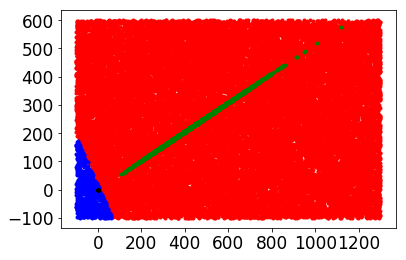

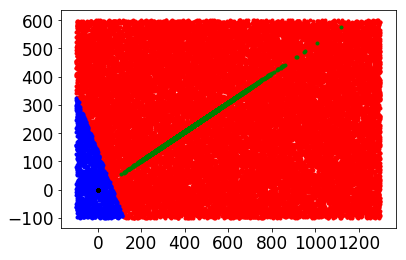

In [20]:
# 1000 epoch
plot_temp_all(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all(feature_random, pre_label_svm,feature_t, label_t)

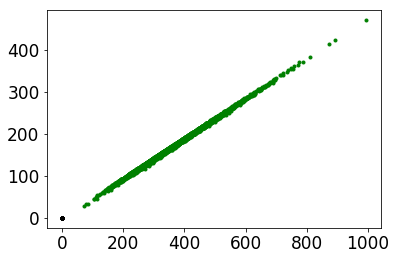

In [14]:
plot_temp(feature_t, label_t)

In [22]:
	plot_blobs_all_together(feature_random, pre_label_nn,feature_t, label_t,
		'../result/exploration/NN_transform_reinitailize.png')
	plot_blobs_all_together(feature_random, pre_label_svm,feature_t, label_t,
		'../result/exploration/SVM_decision_boundary_transform.png')

In [29]:
def adam_variables_initializer(adam_opt, var_list):
    adam_vars = [adam_opt.get_slot(var, name)
                 for name in adam_opt.get_slot_names()
                 for var in var_list if var is not None]
    adam_vars.extend(list(adam_opt._get_beta_accumulators()))
    return tf.variables_initializer(adam_vars)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-6)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
reset_opt_op = tf.variables_initializer([optimizer_sgd_last_layer.get_slot(var, name) 
                for name in optimizer_sgd_last_layer.get_slot_names() for var in last_layer_variables])
session.run(reset_opt_op)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

optimizer_last_layer = tf.train.AdamOptimizer(0.0001)
step_last_layer = optimizer_last_layer.minimize(cost,
                        var_list = last_layer_variables)

reset_opt_vars = adam_variables_initializer(optimizer_last_layer,
                                            last_layer_variables)
session.run(reset_opt_vars)